In [253]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.stats.mstats import gmean
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess 
from skmisc.loess import loess
%matplotlib inline
from itertools import combinations
from itertools import chain

from multiprocessing import Pool
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

tools_path = '../code/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools
from tools import mutant_colorset
from tools import condition_colorset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cov_thresh = 1e6

fitness_data = p.read_csv('../data/DoubleBC_Merged_Fitness_Atish_Weighted_Default_AllConditions_IncludingOld_swapsremoved.csv')

merged_fitness_data = fitness_data

In [4]:
mutant_train_set = p.read_csv('../data/mutant_train_set.csv')
training_bcs = mutant_train_set['barcode'].values

mutant_minimal_train_set = p.read_csv('../data/mutant_minimal_train_set.csv')
minimal_training_bcs = mutant_minimal_train_set['barcode'].values

mutant_minimal_train_set = p.read_csv('../data/mutant_minimal_test_set.csv')
minimal_testing_bcs = mutant_minimal_train_set['barcode'].values

In [5]:
# old_conditions = {
#                   '3':['3.1','3.2','3.3'],
#                   '6':['6.1','6.2','6.3'],
#                   '13':['13.1','13.2','13.3'],
#                   '18':['18.1','18.2','18.3'],
#                   '20':['20.1','20.2','20.3'],
#                   '21':['21.1','21.2','21.3'],
#                   '23':['23.1','23.2','23.3']
#                  }

# bigbatch_conditions = {
#                         '1BB_M3':['A','B','C','D'],
#                         '1BB_Baffle':['E','F'],
#                         '1BB_1.4%Gluc' :['G','H'],
#                         '1BB_1.8%Gluc' :['I','J'],
#                         '1BB_0.2MNaCl' :['K','L'],
# #                         '1BB_0.2MNaCl' :['K'], 
#                         '1BB_0.5MNaCl' :['M','N'],
#                         '1BB_0.2MKCl' :['O'],
#                         '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
#                         '1BB_1%Raf' :['Y','Z'],
#                         '1BB_0.5%Raf' :['AA','BB'],
#                         '1BB_1%Gly' :['CC','DD'],
#                         '1BB_1%EtOH' :['EE','FF'],
#                         '1BB_SucRaf' :['GG'],
#                       }

old_conditions = {
#                   '3':['t3.1','t3.2','t3.3'],
#                   '6':['t6.1','t6.2','t6.3'],
#                   '13':['t13.1','t13.2','t13.3'],
#                   '18':['t18.1','t18.2','t18.3'],
                  '19':['t19.1','t19.2','t19.3'],
#                   '20':['t20.1','t20.2','t20.3'],
#                   '21':['t21.1','t21.2','t21.3'],
#                   '23':['t23.1','t23.2','t23.3'],
                  'M3_Batch_3':['3.1','3.2','3.3'],
                  'M3_Batch_6':['6.1','6.2','6.3'],
                  'M3_Batch_13':['13.1','13.2','13.3'],
                  'M3_Batch_18':['18.1','18.2','18.3'],
#                   'M3_Batch_19':['t19.1','t19.2','t19.3'],
                  'M3_Batch_20':['20.1','20.2','20.3'],
                  'M3_Batch_21':['21.1','21.2','21.3'],
                  'M3_Batch_23':['23.1','23.2','23.3'],

                    ## radicicol
                    ## benomyl
                    ## fluconazole
                    ## Glucose gradient
    
    }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
                        '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.2MNaCl' :['K'], 
                        '1BB_0.5MNaCl' :['M','N'],
                        '1BB_0.2MKCl' :['O'],
                        '1BB_0.5MKCl' :['P'],
                        '1BB_8.5uMGdA' :['Q','R'],
                        '1BB_17uMGdA' :['S','T'],
                        '1BB_2ugFlu' :['U','V'],
                        '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
                        '1BB_1%EtOH' :['EE','FF'],
                        '1BB_SucRaf' :['GG'],
                      }



# old_nonm3_conditions = [
# #     '1.4Glucose', '1.6Glucose', '1.7Glucose', '1.8Glucose',
#        '2.5Glucose', '24_Hour_Transfer_PC', 'Benomyl_2ug/mL',
#        'DMSO', 'Ferm_40_Hour_Transfer', 'Ferm_44_Hour_Transfer',
#        'Ferm_50_Hour_Transfer', 'Ferm_54_Hour_Transfer',
#        'Fluconazole_2ug/mL', 'Geldanamycin8.5uM','Radicicol_5uM', 'Resp_5_Day_Transfer',
#        'Resp_7_Day_Transfer']

old_nonm3_conditions = {'Ferm_44hr_Transfer':['t14.1','t14.2','t14.3'],
                  'Ferm_40hr_Transfer':['t15.1','t15.2','t15.3'],
                  'Ferm_54hr_Transfer':['t16.1','t16.2','t16.3'],
                  'Ferm_50hr_Transfer':['t17.1','t17.2','t17.3'],
                  'Resp_24hr_Transfer':['t5.1','t5.2','t5.3'],
                  'Resp_3Day_Transfer':['t7.1','t7.2','t7.3'],
                  'Resp_4Day_Transfer':['t8.1','t8.2','t8.3'],
                  'Resp_5Day_Transfer':['t25.1','t25.2','t25.3'],
                  'Resp_6Day_Transfer':['t26.1','t26.2','t26.3'],
                  'Resp_7Day_Transfer':['t27.1','t27.2','t27.3'],
                  'DMSO':['t1.1','t1.2','t1.3'],
                  'Geldanamycin8.5uM':['t2.4','t2.5','t2.6'],}

# m3_conditions = {**old_conditions,}
conditions = {**old_conditions, **bigbatch_conditions}
conditions = {**conditions, **old_nonm3_conditions}
all_conditions = conditions.keys()
all_reps = [rep for reps in conditions.values() for rep in reps]

m3_conditions = list(old_conditions.keys()) + ['1BB_M3']
m3_reps = [rep for condition in m3_conditions for rep in conditions[condition]]



In [158]:
diploid_mean = np.mean(merged_fitness_data[merged_fitness_data['gene']=='Diploid']['1BB_M3_fitness'])
diploid_std = np.std(merged_fitness_data[merged_fitness_data['gene']=='Diploid']['1BB_M3_fitness'])

mutation_type = []
for entry in range(len(merged_fitness_data.index)):
    gene_name = merged_fitness_data['gene'].values[entry]
    this_type = merged_fitness_data['type'].values[entry]
    m3_fitness = merged_fitness_data['1BB_M3_fitness'].values[entry]
    if gene_name == 'IRA1':
        if this_type == 'missense_variant':
            mutation_type.append('IRA1_missense')
        elif this_type in ['frameshift_variant','stop_gained']:
            mutation_type.append('IRA1_nonsense')
        else:
            mutation_type.append('IRA1_other')
    elif gene_name == 'Diploid':
        if m3_fitness > diploid_mean+2*diploid_std:
            mutation_type.append('Diploid_adaptive')
        else:
            mutation_type.append('Diploid')
        
    else:
        mutation_type.append(gene_name)
        
            
merged_fitness_data['mutation_type'] = mutation_type

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


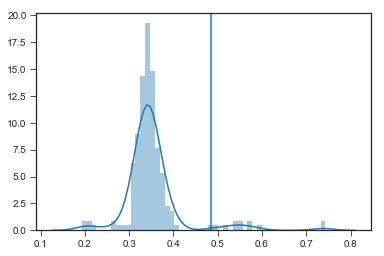

In [155]:
diploid_mean = np.mean(merged_fitness_data[merged_fitness_data['gene']=='Diploid']['1BB_M3_fitness'])
diploid_std = np.std(merged_fitness_data[merged_fitness_data['gene']=='Diploid']['1BB_M3_fitness'])

sns.distplot(merged_fitness_data[merged_fitness_data['gene']=='Diploid']['1BB_M3_fitness'].values)
plt.axvline(diploid_mean+2*diploid_std)

In [7]:
full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))

In [69]:
this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
# this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

train_cols = [col + '_fitness' for col in m3_conditions]
train_conditions = train_cols

test_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in train_cols]
test_cols = test_cols + [col + '_fitness' for col in old_nonm3_conditions.keys()]
test_conditions = test_cols

fitness_cols = train_cols + test_cols

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

# train_cols = [col+'_original_fitness' for col in [col.split('_')[0] for col in fitness_cols] if col in m3_reps]
# test_cols =  [col+'_original_fitness'  for col in [col.split('_')[0] for col in fitness_cols] if col not in m3_reps]



([<matplotlib.axis.YTick at 0x11725ac50>,
 <a list of 6 Text yticklabel objects>)

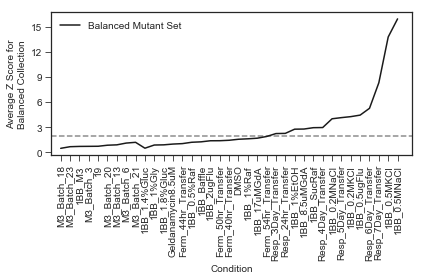

In [70]:
# train_means = np.nanmean(this_data[train_cols].values,axis=1)
# repeated_means = np.repeat(train_means,len(test_cols)).reshape(len(train_means),len(test_cols))
# train_stds = np.nanstd(this_data[train_cols].values,axis=1)
# repeated_stds = np.repeat(train_stds,len(test_cols)).reshape(len(train_stds),len(test_cols))
# test_z_scores = np.abs((this_data[test_cols].values-repeated_means)/repeated_stds)
# train_z_scores = np.abs((this_data[train_cols].values-repeated_means)/repeated_stds)

# sorted_test_cols = np.asarray(test_cols)[np.argsort(np.mean(test_z_scores,axis=0))]
# sorted_train_cols = np.asarray(train_cols)[np.argsort(np.mean(train_z_scores,axis=0))]
# # plt.plot(sorted(np.mean(train_z_scores,axis=0))+sorted(np.mean(test_z_scores,axis=0)),'o',label='All Mutants (dominated by Diploids)')


# all_cols = list(sorted_train_cols)+list(sorted_test_cols)
# plt.xticks(range(len(all_cols)),[col.split('_fitness')[0] for col in (all_cols)],rotation=90)


used_mutants = [bc for bc in this_data['barcode'].values if bc in (list(minimal_training_bcs) + list(minimal_testing_bcs))]
      
    

all_mut_locs =sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))


train_means = np.nanmean(this_data[train_cols].values[all_mut_locs,:],axis=1)
repeated_means = np.repeat(train_means,len(test_cols)).reshape(len(train_means),len(test_cols))
train_stds = np.nanstd(this_data[train_cols].values[all_mut_locs,:],axis=1)
repeated_stds = np.repeat(train_stds,len(test_cols)).reshape(len(train_stds),len(test_cols))
test_z_scores = np.abs((this_data[test_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

train_means = np.nanmean(this_data[train_cols].values[all_mut_locs,:],axis=1)
repeated_means = np.repeat(train_means,len(train_cols)).reshape(len(train_means),len(train_cols))
train_stds = np.nanstd(this_data[train_cols].values[all_mut_locs,:],axis=1)
repeated_stds = np.repeat(train_stds,len(train_cols)).reshape(len(train_stds),len(train_cols))
train_z_scores = np.abs((this_data[train_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

mean_train_z_scores = train_z_scores
mean_test_z_scores = test_z_scores

sorted_test_cols = np.asarray(test_cols)[np.argsort(np.mean(test_z_scores,axis=0))]
sorted_train_cols = np.asarray(train_cols)[np.argsort(np.mean(train_z_scores,axis=0))]
plt.plot(sorted(np.mean(train_z_scores,axis=0))+sorted(np.mean(test_z_scores,axis=0)),'-',color='k',alpha=1.0,label='Balanced Mutant Set')


all_cols = list(sorted_train_cols)+list(sorted_test_cols)
plt.xticks(range(len(all_cols)),[col.split('_fitness')[0] for col in (all_cols)],rotation=90)

plt.legend()
# plt.ylim(0,7)
plt.xlim(-1,len(train_conditions)+len(test_conditions)+0.5)
plt.ylabel('Average Z Score for\nBalanced Collection')
plt.xlabel('Condition')

plt.tight_layout()
plt.axhline(2,color='k',linestyle='--',alpha=0.5)
plt.yticks(range(0,16,3),range(0,16,3))
# plt.savefig('z_scores_minimal_comparison.pdf',bbox_inches='tight')

In [71]:
np.asarray(all_cols)[np.where(np.asarray(sorted(np.mean(train_z_scores,axis=0))+sorted(np.mean(test_z_scores,axis=0))) < 2.0)]

array(['M3_Batch_18_fitness', 'M3_Batch_23_fitness', '1BB_M3_fitness',
       'M3_Batch_3_fitness', '19_fitness', 'M3_Batch_20_fitness',
       'M3_Batch_13_fitness', 'M3_Batch_6_fitness', 'M3_Batch_21_fitness',
       '1BB_1.4%Gluc_fitness', '1BB_1%Gly_fitness',
       '1BB_1.8%Gluc_fitness', 'Geldanamycin8.5uM_fitness',
       'Ferm_44hr_Transfer_fitness', '1BB_0.5%Raf_fitness',
       '1BB_Baffle_fitness', '1BB_2ugFlu_fitness',
       'Ferm_50hr_Transfer_fitness', 'Ferm_40hr_Transfer_fitness',
       'DMSO_fitness', '1BB_1%Raf_fitness', '1BB_17uMGdA_fitness',
       'Ferm_54hr_Transfer_fitness'], dtype='<U26')

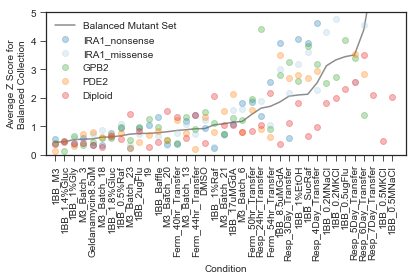

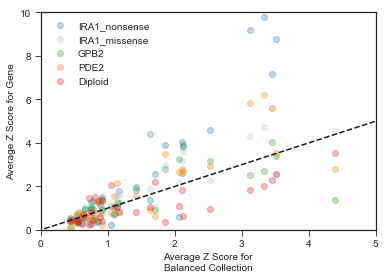

In [159]:
# train_means = np.nanmean(this_data[train_cols].values,axis=1)
# repeated_means = np.repeat(train_means,len(test_cols)).reshape(len(train_means),len(test_cols))
# train_stds = np.nanstd(this_data[train_cols].values,axis=1)
# repeated_stds = np.repeat(train_stds,len(test_cols)).reshape(len(train_stds),len(test_cols))
# test_z_scores = np.abs((this_data[test_cols].values-repeated_means)/repeated_stds)
# train_z_scores = np.abs((this_data[train_cols].values-repeated_means)/repeated_stds)

# sorted_test_cols = np.asarray(test_cols)[np.argsort(np.mean(test_z_scores,axis=0))]
# sorted_train_cols = np.asarray(train_cols)[np.argsort(np.mean(train_z_scores,axis=0))]
# # plt.plot(sorted(np.mean(train_z_scores,axis=0))+sorted(np.mean(test_z_scores,axis=0)),'o',label='All Mutants (dominated by Diploids)')


# all_cols = list(sorted_train_cols)+list(sorted_test_cols)
# plt.xticks(range(len(all_cols)),[col.split('_fitness')[0] for col in (all_cols)],rotation=90)


used_mutants = [bc for bc in this_data['barcode'].values if bc in (list(minimal_training_bcs) + list(minimal_testing_bcs))]
      
    

all_mut_locs =sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))


train_means = np.nanmean(this_data[train_cols].values[all_mut_locs,:],axis=1)
repeated_means = np.repeat(train_means,len(test_cols)).reshape(len(train_means),len(test_cols))
train_stds = np.nanstd(this_data[train_cols].values[all_mut_locs,:],axis=1)
repeated_stds = np.repeat(train_stds,len(test_cols)).reshape(len(train_stds),len(test_cols))
test_z_scores = np.abs((this_data[test_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

train_means = np.nanmean(this_data[train_cols].values[all_mut_locs,:],axis=1)
repeated_means = np.repeat(train_means,len(train_cols)).reshape(len(train_means),len(train_cols))
train_stds = np.nanstd(this_data[train_cols].values[all_mut_locs,:],axis=1)
repeated_stds = np.repeat(train_stds,len(train_cols)).reshape(len(train_stds),len(train_cols))
train_z_scores = np.abs((this_data[train_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

mean_train_z_scores = train_z_scores
mean_test_z_scores = test_z_scores

sorted_test_cols = np.asarray(test_cols)[np.argsort(np.mean(test_z_scores,axis=0))]
sorted_train_cols = np.asarray(train_cols)[np.argsort(np.mean(train_z_scores,axis=0))]
plt.plot(sorted(np.mean(train_z_scores,axis=0))+sorted(np.mean(test_z_scores,axis=0)),'-',color='k',alpha=0.5,label='Balanced Mutant Set')


all_cols = list(sorted_train_cols)+list(sorted_test_cols)
plt.xticks(range(len(all_cols)),[col.split('_fitness')[0] for col in (all_cols)],rotation=90)

plt.legend()
# plt.ylim(0,7)
plt.xlim(-1,len(train_conditions)+len(test_conditions)+0.5)
plt.ylabel('Average Z Score for\nBalanced Collection')
plt.xlabel('Condition')

plt.tight_layout()

# plt.savefig('z_scores_minimal_comparison.pdf',bbox_inches='tight')

gene_list = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid']
for gene in gene_list:
    
    used_mutants = [bc for bc in this_data[this_data['mutation_type']==gene]['barcode'].values]
    all_mut_locs =sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))


    train_means = np.nanmean(this_data[train_cols].values[all_mut_locs,:],axis=1)
    repeated_means = np.repeat(train_means,len(test_cols)).reshape(len(train_means),len(test_cols))
    train_stds = np.nanstd(this_data[train_cols].values[all_mut_locs,:],axis=1)
    repeated_stds = np.repeat(train_stds,len(test_cols)).reshape(len(train_stds),len(test_cols))
    test_z_scores = np.abs((this_data[test_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

    train_means = np.nanmean(this_data[train_cols].values[all_mut_locs,:],axis=1)
    repeated_means = np.repeat(train_means,len(train_cols)).reshape(len(train_means),len(train_cols))
    train_stds = np.nanstd(this_data[train_cols].values[all_mut_locs,:],axis=1)
    repeated_stds = np.repeat(train_stds,len(train_cols)).reshape(len(train_stds),len(train_cols))
    train_z_scores = np.abs((this_data[train_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

    sorted_test_cols = np.asarray(test_cols)[np.argsort(np.mean(mean_test_z_scores,axis=0))]
    sorted_train_cols = np.asarray(train_cols)[np.argsort(np.mean(mean_train_z_scores,axis=0))]
    plt.plot((list(np.mean(train_z_scores,axis=0)[np.argsort(np.mean(mean_train_z_scores,axis=0))])+
              list(np.mean(test_z_scores,axis=0)[np.argsort(np.mean(mean_test_z_scores,axis=0))]))
             ,'o',color=mutant_colorset[gene],alpha=0.3,label=gene)
plt.legend()
# plt.axhline(2.0)

# plt.savefig('z_scores_minimal_comparison_plusmore.pdf',bbox_inches='tight')

plt.ylim(0,5)
# plt.savefig('z_scores_minimal_comparison_plusmore_zoomed.pdf',bbox_inches='tight')   


# gene_list = ['IRA1','GPB2','PDE2','Diploid']
gene_list = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid']

mean_std_bygene = {}

plt.figure()
for gene in gene_list:
    
#     plt.figure()
    
#     plt.title(gene)
    
    used_mutants = [bc for bc in this_data[this_data['mutation_type']==gene]['barcode'].values]
    all_mut_locs =sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))


    train_means = np.nanmean(this_data[train_cols].values[all_mut_locs,:],axis=1)
    repeated_means = np.repeat(train_means,len(test_cols)).reshape(len(train_means),len(test_cols))
    train_stds = np.nanstd(this_data[train_cols].values[all_mut_locs,:],axis=1)
    repeated_stds = np.repeat(train_stds,len(test_cols)).reshape(len(train_stds),len(test_cols))
    test_z_scores = np.abs((this_data[test_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)
    
    mean_std_bygene[gene] = [np.mean(train_means),np.mean(train_stds)]

    train_means = np.nanmean(this_data[train_cols].values[all_mut_locs,:],axis=1)
    repeated_means = np.repeat(train_means,len(train_cols)).reshape(len(train_means),len(train_cols))
    train_stds = np.nanstd(this_data[train_cols].values[all_mut_locs,:],axis=1)
    repeated_stds = np.repeat(train_stds,len(train_cols)).reshape(len(train_stds),len(train_cols))
    train_z_scores = np.abs((this_data[train_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

    sorted_test_cols = np.asarray(test_cols)[np.argsort(np.mean(mean_test_z_scores,axis=0))]
    sorted_train_cols = np.asarray(train_cols)[np.argsort(np.mean(mean_train_z_scores,axis=0))]
#     plt.plot((list(np.mean(train_z_scores,axis=0)[np.argsort(np.mean(mean_train_z_scores,axis=0))])+
#               list(np.mean(test_z_scores,axis=0)[np.argsort(np.mean(mean_test_z_scores,axis=0))]))
#              ,'o',color=mutant_colorset[gene],alpha=0.3,label=gene)
    
    
    plt.plot((list(np.mean(mean_train_z_scores,axis=0)[np.argsort(np.mean(mean_train_z_scores,axis=0))])+
              list(np.mean(mean_test_z_scores,axis=0)[np.argsort(np.mean(mean_test_z_scores,axis=0))])),
             (list(np.mean(train_z_scores,axis=0)[np.argsort(np.mean(mean_train_z_scores,axis=0))])+
              list(np.mean(test_z_scores,axis=0)[np.argsort(np.mean(mean_test_z_scores,axis=0))]))
             ,'o',color=mutant_colorset[gene],alpha=0.3,label=gene)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
onetoone = [min([xmin,ymin]),max([xmax,ymax])]
plt.plot(onetoone,onetoone,'k--')
plt.legend()
plt.xlabel('Average Z Score for\nBalanced Collection')
plt.ylabel('Average Z Score for Gene')
plt.xlim(0,20)
plt.savefig('z_score_comparison_allgenes.pdf')

plt.xlim(0,5)
plt.ylim(0,10)
plt.savefig('z_score_comparison_allgenes_zoomed.pdf')
    
    




In [167]:
# test_mutant_data = this_data[~this_data['barcode'].isin(minimal_training_bcs)]

interesting_behavior = {}


mutant_data = this_data[this_data['barcode'].isin((list(minimal_training_bcs)+list(minimal_testing_bcs)))]

train_conditions = sorted_train_cols
test_conditions = sorted_test_cols


# this_gene = ['GPB2','IRA1','PDE2','Diploid']
this_gene = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid']
this_gene_data = mutant_data[mutant_data['mutation_type'].isin(this_gene)]


this_gene_locs = np.where(np.isin(mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[train_conditions[0]].values)) ]


all_conditions = list(train_conditions) + list(test_conditions)

    
for g,gene in enumerate(this_gene):
    interesting_behavior[gene] = []
    mean = mean_std_bygene[gene][0]
    twosigma_top = mean_std_bygene[gene][0]+2*mean_std_bygene[gene][1]
    twosigma_bottom = mean_std_bygene[gene][0]-2*mean_std_bygene[gene][1]

    this_gene_data = mutant_data[mutant_data['mutation_type']==gene]
    data = np.median(np.asarray([this_gene_data[col].values for col in all_conditions]),axis=1)
    
    for i,condition in enumerate(all_conditions):
        if not twosigma_bottom < data[i] < twosigma_top:
            interesting_behavior[gene].append(condition)
            


In [175]:
interesting_behavior

{'Diploid': ['1BB_1%Raf_fitness',
  'Ferm_54hr_Transfer_fitness',
  '1BB_0.5ugFlu_fitness',
  'Resp_6Day_Transfer_fitness'],
 'GPB2': ['Resp_24hr_Transfer_fitness',
  '1BB_8.5uMGdA_fitness',
  'Resp_3Day_Transfer_fitness',
  '1BB_1%EtOH_fitness',
  '1BB_SucRaf_fitness',
  'Resp_4Day_Transfer_fitness',
  '1BB_0.2MNaCl_fitness',
  '1BB_0.2MKCl_fitness',
  '1BB_0.5ugFlu_fitness',
  'Resp_5Day_Transfer_fitness',
  'Resp_7Day_Transfer_fitness',
  '1BB_0.5MKCl_fitness',
  '1BB_0.5MNaCl_fitness'],
 'IRA1_missense': ['Ferm_50hr_Transfer_fitness',
  '1BB_8.5uMGdA_fitness',
  '1BB_1%EtOH_fitness',
  '1BB_SucRaf_fitness',
  '1BB_0.2MNaCl_fitness',
  '1BB_0.2MKCl_fitness',
  '1BB_0.5ugFlu_fitness',
  'Resp_6Day_Transfer_fitness',
  'Resp_7Day_Transfer_fitness',
  '1BB_0.5MKCl_fitness',
  '1BB_0.5MNaCl_fitness'],
 'IRA1_nonsense': ['Ferm_54hr_Transfer_fitness',
  '1BB_8.5uMGdA_fitness',
  '1BB_1%EtOH_fitness',
  '1BB_SucRaf_fitness',
  'Resp_4Day_Transfer_fitness',
  '1BB_0.2MNaCl_fitness',
  '1BB_

In [182]:
m3_cols

['1BB_M3_fitness',
 '1BB_1.4%Gluc_fitness',
 '1BB_1%Gly_fitness',
 'M3_Batch_3_fitness',
 'Geldanamycin8.5uM_fitness',
 'M3_Batch_18_fitness',
 '1BB_1.8%Gluc_fitness',
 '1BB_0.5%Raf_fitness',
 'M3_Batch_23_fitness',
 '1BB_2ugFlu_fitness',
 '19_fitness',
 '1BB_Baffle_fitness',
 'M3_Batch_20_fitness',
 'Ferm_40hr_Transfer_fitness',
 'M3_Batch_13_fitness',
 'Ferm_44hr_Transfer_fitness',
 'DMSO_fitness',
 '1BB_1%Raf_fitness',
 'M3_Batch_21_fitness',
 '1BB_17uMGdA_fitness',
 'M3_Batch_6_fitness',
 'Ferm_50hr_Transfer_fitness']

In [169]:
m3_cols = list(sorted_train_cols)
nonm3_cols = list(sorted_test_cols)

In [184]:
# %%notify

this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()
this_data = this_data.sort_values('barcode')

this_data['batch_mean'] = np.mean(this_data[[col for col in sorted_train_cols]].values,axis=1)

last_subtle = 13

train_cols = list(m3_cols) + list(nonm3_cols[:last_subtle])
train_cols = list(m3_cols)
# test_cols = list(nonm3_cols[last_subtle:])+['batch_mean']

test_cols = list(nonm3_cols[last_subtle:])
test_cols = list(nonm3_cols)
# test_cols = ['batch_mean']

fitness_cols = train_cols + test_cols

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

train_conditions = train_cols
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

test_conditions = test_cols
test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]

all_locs = sorted(list(train_locs)+list(test_locs))

used_mutants = [bc for bc in this_data['barcode'].values if bc in (list(minimal_training_bcs) + list(minimal_testing_bcs))]

all_mut_locs =sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))

this_fitness = fitness[all_mut_locs,:][:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]  

train = [new_train_locs,np.where(np.isin(used_mutants,minimal_training_bcs))[0]]
test = [new_test_locs,np.where(np.isin(used_mutants,minimal_testing_bcs))[0]]



In [185]:
fit_by_rank, fits_by_condition, fits_by_mutant, mean_fits,mean_fits_by_condition, guesses = tools.SVD_predictions_train_test(this_fitness,train,test,by_condition=True,by_mutant=True)

In [186]:
guesses

[array([[ 0.22600807,  0.32815537,  0.16255833, ..., -0.22861234,
         -0.80710992, -1.00194187],
        [ 0.16864954,  0.2448729 ,  0.1213027 , ..., -0.17059288,
         -0.6022737 , -0.7476593 ],
        [ 0.56567752,  0.82134285,  0.40686864, ..., -0.57219577,
         -2.02012227, -2.50776881],
        ...,
        [ 0.37150822,  0.53941621,  0.26721062, ..., -0.37578908,
         -1.32671355, -1.64697499],
        [ 0.07602718,  0.11038865,  0.05468323, ..., -0.07690323,
         -0.27150485, -0.33704464],
        [ 0.19800835,  0.2875008 ,  0.14241928, ..., -0.20028998,
         -0.70711856, -0.87781314]]),
 array([[ 0.28100561,  0.48298474,  0.28733446, ...,  0.20729494,
         -0.048721  ,  0.03903853],
        [ 0.26045901,  0.50333542,  0.3295962 , ...,  0.55708361,
          0.66373354,  0.99008856],
        [ 0.56769766,  0.82702996,  0.41145184, ..., -0.55618428,
         -1.99226556, -2.46953212],
        ...,
        [ 0.39959444,  0.61848466,  0.33093145, ..., -

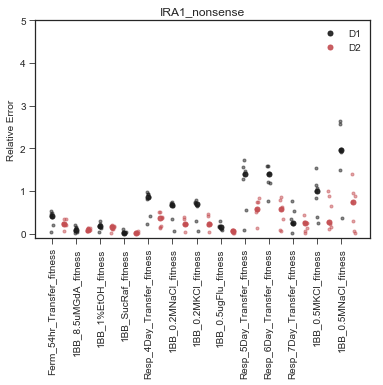

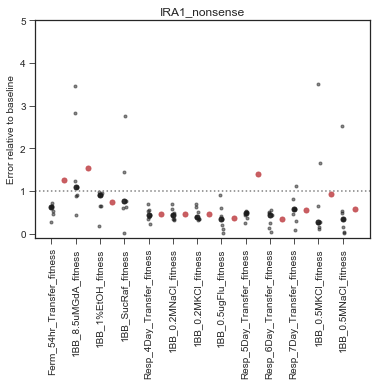

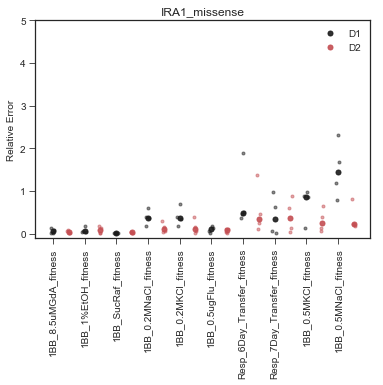

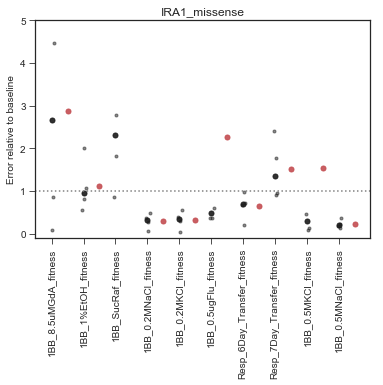

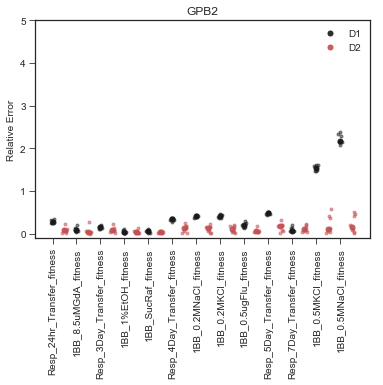

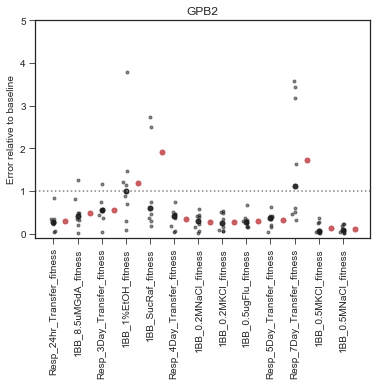

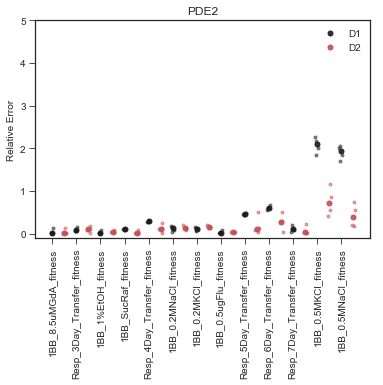

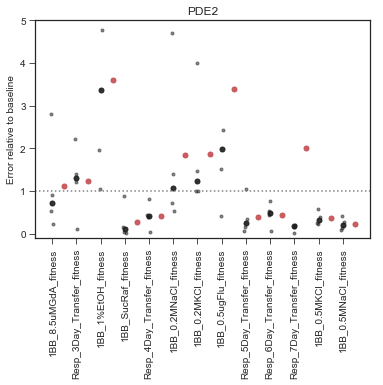

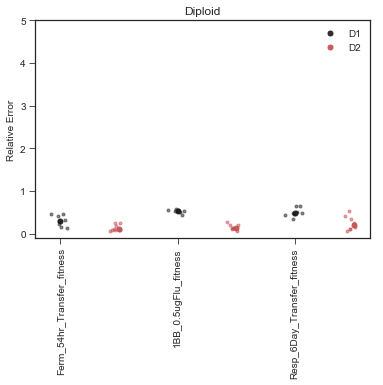

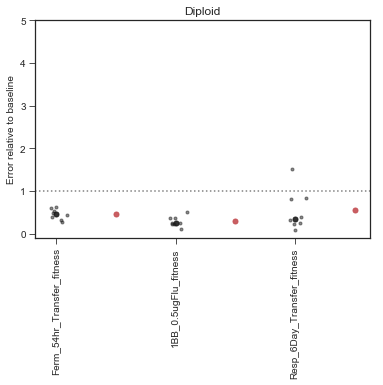

In [316]:
train_c = train[0]
train_m = train[1]

test_c = test[0]
test_m = test[1]

model_colors = ['k','r']

both_new = this_fitness[np.repeat(test_m,len(test_c)),np.tile(test_c,len(test_m))].reshape(len(test_m),len(test_c))

for this_gene,these_conditions in interesting_behavior.items():
    
    plt.figure()
    plt.title(this_gene)
    
    this_gene_data = this_data[this_data['mutation_type'] == this_gene]

    prediction_conditions = [condition for condition in these_conditions if condition in test_conditions]
    
    this_gene_locs = np.where(np.isin(minimal_testing_bcs,this_gene_data['barcode'].values))[0]
    this_condition_locs = np.where(np.isin(test_conditions,prediction_conditions))
    

    for m,model in enumerate([0,5]):
        guess = guesses[model][this_gene_locs,:][:,this_condition_locs]
        guess = guess.reshape(guess.shape[0],guess.shape[2])
        truth = both_new[this_gene_locs,:][:,this_condition_locs]
        truth = truth.reshape(truth.shape[0],truth.shape[2])
        error = np.abs((guess-truth))
        for bc in range(error.shape[0]):
            this_jitter = tools.jitter_point(0,0.05)
            plt.plot(np.arange(m*0.5+this_jitter,len(prediction_conditions)+m*0.5+this_jitter),error[bc,:],'.',color=model_colors[m],alpha=0.5)
        plt.plot(np.arange(m*0.5,len(prediction_conditions)+m*0.5),np.median(error,axis=0),'o',markersize=5,color=model_colors[m],alpha=0.9,label=f'D{m+1}')



        
    plt.xticks(range(len(prediction_conditions)),prediction_conditions,rotation=90)
    plt.ylim(-0.1,5)
    plt.legend()
    
    plt.ylabel('Relative Error')
    plt.savefig(f'interesting_behavior_{this_gene}_actualfits.pdf',bbox_inches='tight')
    
    
    
    plt.figure()
    plt.title(this_gene)
    truth = both_new[this_gene_locs,:][:,this_condition_locs]
    truth = truth.reshape(truth.shape[0],truth.shape[2])

    guess = guesses[0][this_gene_locs,:][:,this_condition_locs]
    guess = guess.reshape(guess.shape[0],guess.shape[2])

    baseline_error = np.abs((guess-truth))
    for m,model in enumerate([5]):
        guess = guesses[model][this_gene_locs,:][:,this_condition_locs]
        guess = guess.reshape(guess.shape[0],guess.shape[2])
        truth = both_new[this_gene_locs,:][:,this_condition_locs]
        truth = truth.reshape(truth.shape[0],truth.shape[2])
        relative_error = np.abs((guess-truth))/baseline_error
        for bc in range(error.shape[0]):
            this_jitter = tools.jitter_point(0,0.05)
            plt.plot(np.arange(m*0.5+this_jitter,len(prediction_conditions)+m*0.5+this_jitter),relative_error[bc,:],'.',color=model_colors[m],alpha=0.5)
        plt.plot(np.arange(m*0.5,len(prediction_conditions)+m*0.5),np.median(relative_error,axis=0),'o',markersize=5,color=model_colors[m],alpha=0.9)
        plt.plot(np.arange((m+1)*0.5,len(prediction_conditions)+(m+1)*0.5),np.mean(relative_error,axis=0),'o',markersize=5,color='r',alpha=0.9)


        
        plt.xticks(range(len(prediction_conditions)),prediction_conditions,rotation=90)
#         plt.ylim(-0.1,5)
    
        plt.ylabel('Error relative to baseline')
        plt.axhline(y=1,color='gray',linestyle=':')
        plt.savefig(f'interesting_behavior_{this_gene}_relative_to_1.pdf',bbox_inches='tight')
        plt.ylim(-0.1,5)
        plt.savefig(f'interesting_behavior_{this_gene}_relative_to_1_ylim.pdf',bbox_inches='tight')
    
    
    
 

    
    
    

A few different (all potentially interesting) ways to identify if we're appropriately detecting "interesting" behavior:

(1) Average (or median) error in prediction for 1D vs 6D models. (show actual change)

(2) Actual relative error do 1D.

(3) How well does the geometric median of the genes predict the interesting behavior?

In [310]:
this_jitter

-0.007122504859497918

In [188]:
np.median(error,axis=0)

array([0.09782699, 0.1310641 , 0.20087927])

In [189]:
model = 1

fit, train_muts, test_muts, train_cond, test_cond = tools.SVD_mixnmatch_locations(this_fitness,train,test,range(1))
all_muts1 = np.concatenate((train_muts,test_muts))
all_muts1 = all_muts1[np.argsort(np.concatenate((train[1],test[1])))]

distances_1 = distance.pdist(all_muts1)
distances_1_cb = distance.pdist(all_muts1,'cityblock')

0.48741993052454413


In [190]:
model = 6

fit, train_muts, test_muts, train_cond, test_cond = tools.SVD_mixnmatch_locations(this_fitness,train,test,range(6))
all_muts6 = np.concatenate((train_muts,test_muts))
all_muts6 = all_muts6[np.argsort(np.concatenate((train[1],test[1])))]

distances_6 = distance.pdist(all_muts6)
distances_6_cb = distance.pdist(all_muts6,'cityblock')

0.5575600043020863


Take geometric median of each gene. Then see distance between geometric median of these genes in various spaces.

HOW REPRESENTATIVE IS THE GEOMETRIC MEDIAN? HOW SIMILAR ARE MEMBERS OF A GIVEN GENE/MUTATION TYPE? LOOK AT THE AVERAGE DISTANCE OF THESE GENES FROM THE GEOMETRIC MEDIAN?

In [206]:
geom_medians6= {}
geom_medians1= {}

avg_pairwise6= {}
avg_pairwise1= {}

distance_from_median_stats = {}


gene_list = ['GPB2','PDE2','IRA1','Diploid']
gene_list = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid']

for gene in gene_list:
    these_locs = np.where(np.isin(used_mutants,this_data[this_data['mutation_type']==gene]['barcode'].values))
    print(gene,len(these_locs[0]))
    geom_medians6[gene] = tools.geometric_median(all_muts6[these_locs,:][0])
    geom_medians1[gene] = tools.geometric_median(all_muts1[these_locs,:][0])
    
    avg_pairwise6[gene] = np.mean(distance.pdist(all_muts6[these_locs,:][0]))
    avg_pairwise1[gene] = np.mean(distance.pdist(all_muts1[these_locs,:][0]))
    
    distances_from_median[gene] = []
    for loc in these_locs[0]:
        distances_from_median[gene].append(distance.euclidean(all_muts6[loc,:][0],geom_medians6[gene]))
    
    distance_from_median_stats[gene] = {'mean':np.mean(distances_from_median[gene]),
                                        'std':np.std(distances_from_median[gene]),
                                       'median':np.median(distances_from_median[gene]),
                                       'max':np.max(distances_from_median[gene]),
                                       'min':np.min(distances_from_median[gene]),}
    


IRA1_nonsense 11
IRA1_missense 6
GPB2 12
PDE2 7
Diploid 9


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


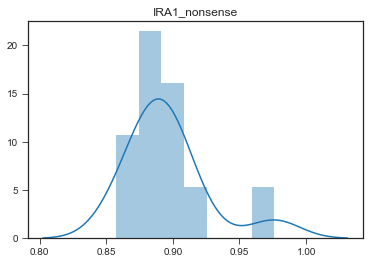

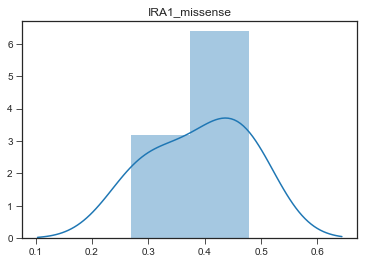

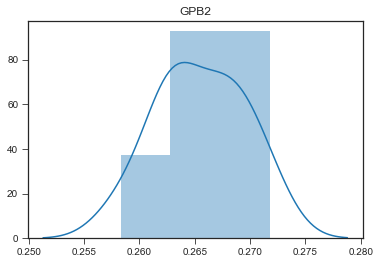

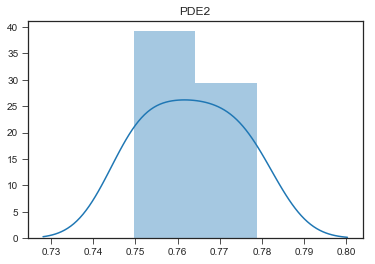

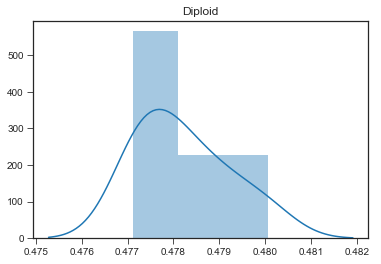

In [192]:
for gene in gene_list:
    plt.figure()
    plt.title(gene)
    sns.distplot(distances_from_median[gene])

In [193]:
distance_from_median_stats

{'Diploid': {'max': 0.48007107484894757,
  'mean': 0.47820447387913606,
  'median': 0.47792921219200746,
  'min': 0.4771216337767426,
  'std': 0.0009538899866198132},
 'GPB2': {'max': 0.27179401505413303,
  'mean': 0.26551643373250117,
  'median': 0.2652407777241199,
  'min': 0.2583049937355897,
  'std': 0.0038344404643545315},
 'IRA1_missense': {'max': 0.4779293471831247,
  'mean': 0.39063756672598454,
  'median': 0.40370072801337475,
  'min': 0.2691471468589873,
  'std': 0.07895579682013415},
 'IRA1_nonsense': {'max': 0.9760802103222755,
  'mean': 0.8958245258557799,
  'median': 0.888449994805044,
  'min': 0.8574577970729156,
  'std': 0.02957234567644098},
 'PDE2': {'max': 0.7787940218669857,
  'mean': 0.7631119704537825,
  'median': 0.7630686753242273,
  'min': 0.749611951748629,
  'std': 0.010574319157986733}}

In [262]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [268]:
len(running_mean(sorted_d6,100))
# len(sorted_d1)

7902

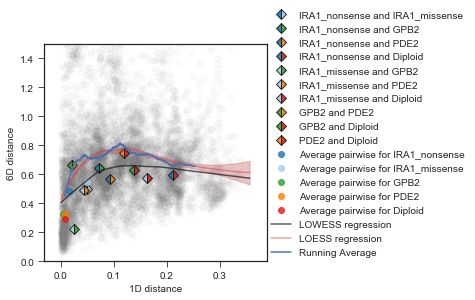

In [284]:
# plt.figure(figsize=(4,4))

# mean1 = np.mean(distances_1)
# mean6 = np.mean(distances_6)

# # plt.scatter(distances_1,distances_6,alpha=0.03,color='gray')
# plt.scatter(distances_1/mean1,distances_6/mean6,alpha=0.03,color='gray')

# # g = sns.jointplot(distances_1,distances_6,alpha=0.03,color='k')
# plt.xlabel('1D distance')
# plt.ylabel('6D distance')



# with sns.color_palette("pastel"):
#     for gene1, gene2 in combinations(gene_list,2):
# #         plt.plot(distance.euclidean(geom_medians1[gene1],geom_medians1[gene2]),
# #                     distance.euclidean(geom_medians6[gene1],geom_medians6[gene2]),
# #                     label=f'{gene1} and {gene2}',color=tools.mutant_colorset[gene1],marker='D',fillstyle = 'left',
# #                 markerfacecoloralt=tools.mutant_colorset[gene2],linestyle='',markersize=7,markeredgecolor='k',alpha=0.9)
#         plt.plot(distance.euclidean(geom_medians1[gene1],geom_medians1[gene2])/mean1,
#                     distance.euclidean(geom_medians6[gene1],geom_medians6[gene2])/mean6,
#                     label=f'{gene1} and {gene2}',color=tools.mutant_colorset[gene1],marker='D',fillstyle = 'left',
#                 markerfacecoloralt=tools.mutant_colorset[gene2],linestyle='',markersize=7,markeredgecolor='k',alpha=0.9)


# plt.legend(loc=(1.0,0.0))

plt.figure(figsize=(4,4))

mean1 = np.mean(distances_1)
mean6 = np.mean(distances_6)



plt.scatter(distances_1,distances_6,alpha=0.03,color='gray')
# plt.scatter(distances_1/mean1,distances_6/mean6,alpha=0.03,color='gray')
# plt.scatter(mean1,mean6,alpha=0.8,color='k',marker='o')

# g = sns.jointplot(distances_1,distances_6,alpha=0.03,color='k')
plt.xlabel('1D distance')
plt.ylabel('6D distance')



with sns.color_palette("pastel"):
    for gene1, gene2 in combinations(gene_list,2):
        plt.plot(distance.euclidean(geom_medians1[gene1],geom_medians1[gene2]),
                    distance.euclidean(geom_medians6[gene1],geom_medians6[gene2]),
                    label=f'{gene1} and {gene2}',color=tools.mutant_colorset[gene1],marker='D',fillstyle = 'left',
                markerfacecoloralt=tools.mutant_colorset[gene2],linestyle='',markersize=7,markeredgecolor='k',alpha=0.9)
#         plt.plot(distance.euclidean(geom_medians1[gene1],geom_medians1[gene2])/mean1,
#                     distance.euclidean(geom_medians6[gene1],geom_medians6[gene2])/mean6,
#                     label=f'{gene1} and {gene2}',color=tools.mutant_colorset[gene1],marker='D',fillstyle = 'left',
#                 markerfacecoloralt=tools.mutant_colorset[gene2],linestyle='',markersize=7,markeredgecolor='k',alpha=0.9)
    for gene in gene_list:
        plt.plot(avg_pairwise1[gene],avg_pairwise6[gene],marker='o',linestyle='',color=tools.mutant_colorset[gene],alpha=0.8,label=f'Average pairwise for {gene}')

lowess_out = lowess(distances_6,distances_1)
plt.plot(lowess_out[:,0],lowess_out[:,1],'k',alpha=0.7,label='LOWESS regression')

sorted_d1 = sorted(distances_1)
sorted_d6 = distances_6[np.argsort(distances_1)]
l = loess(sorted_d1,sorted_d6)
l.fit()
pred = l.predict(sorted_d1, stderror=True)
conf = pred.confidence()
out = pred.values
ll = conf.lower
ul = conf.upper

plt.plot(sorted_d1, out,'r',alpha=0.5,label='LOESS regression')
plt.fill_between(sorted_d1,ll,ul,alpha=.33,color='r')

N = 1000
plt.plot(running_mean(sorted_d1,N),running_mean(sorted_d6,N),color='b',label='Running Average')


    
plt.legend(loc=(1.0,0.0))
plt.savefig('D1_vs_D6_distance_with_regression.pdf',bbox_inches='tight')

plt.ylim(0,1.5)
plt.savefig('D1_vs_D6_distance_with_regression_ylim.pdf',bbox_inches='tight')
# plt.xlim(0,0.5)


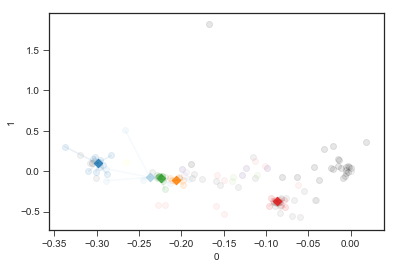

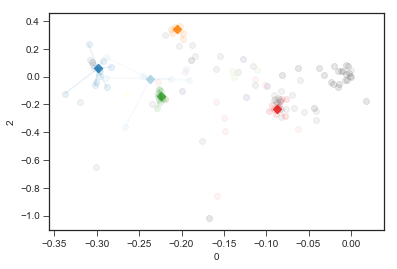

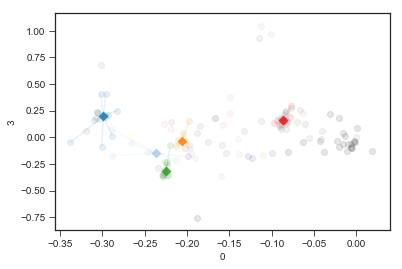

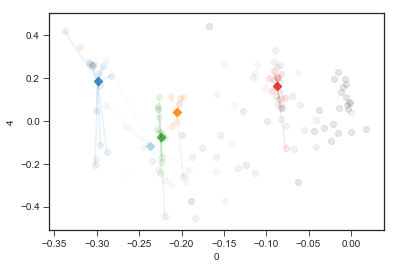

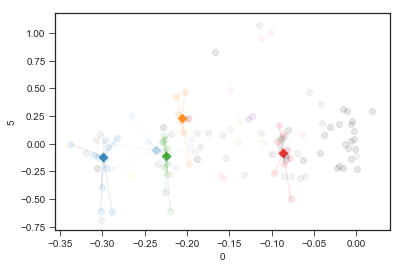

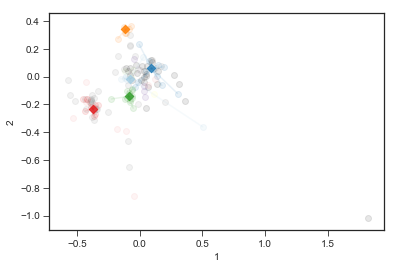

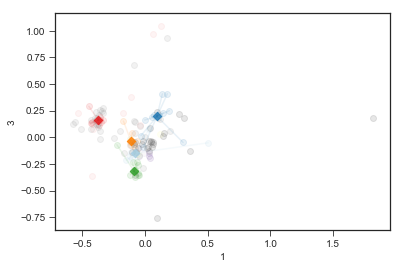

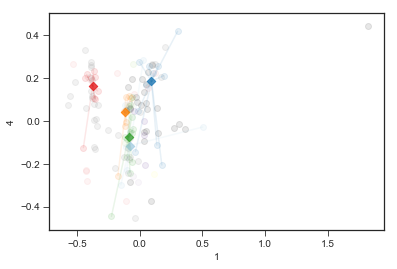

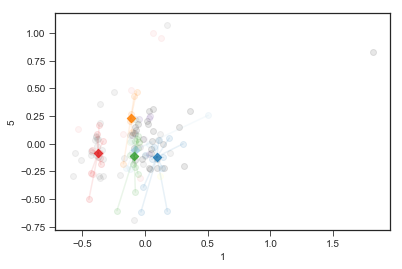

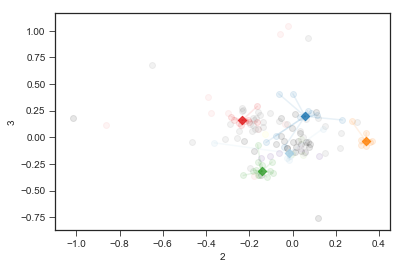

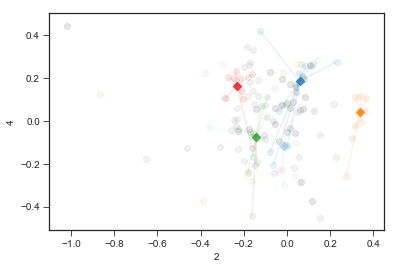

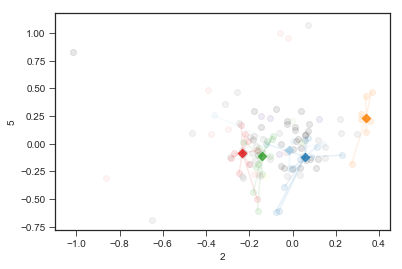

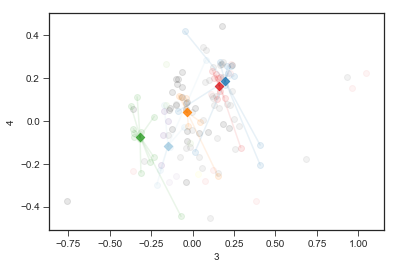

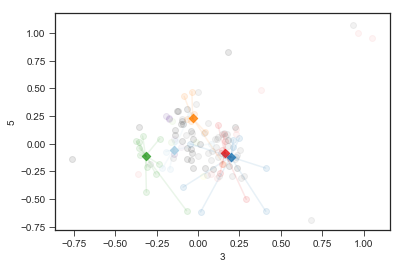

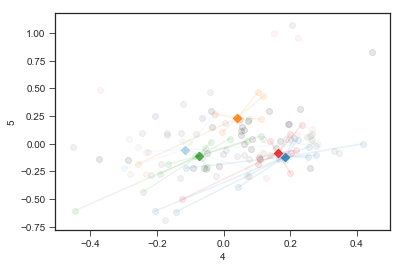

In [197]:
for x,y in combinations(range(model),2):
    plt.figure()
    for c,bc in enumerate(used_mutants):
        genename = this_data[this_data['barcode']==bc]['mutation_type'].values[0]
        plt.scatter(all_muts6[c][x],all_muts6[c][y],color=tools.mutant_colorset[genename],alpha=0.1,marker='o')
        if genename in gene_list:
            plt.plot([all_muts6[c][x],geom_medians6[genename][x]],[all_muts6[c][y],geom_medians6[genename][y]],
                 color=tools.mutant_colorset[genename],alpha=0.1)
    
    for gene in gene_list:
        plt.scatter(geom_medians6[gene][x],geom_medians6[gene][y],color=tools.mutant_colorset[gene],alpha=0.8,marker='D')
#         plt.scatter(centroids[gene][x],centroids[gene][y],color=mutant_colorset[gene],alpha=0.8,marker='*')
    
    plt.xlabel(x)
    plt.ylabel(y)

In [ ]:
train_c = train[0]
train_m = train[1]

test_c = test[0]
test_m = test[1]

model_colors = ['k','r']

both_new = this_fitness[np.repeat(test_m,len(test_c)),np.tile(test_c,len(test_m))].reshape(len(test_m),len(test_c))

for this_gene,these_conditions in interesting_behavior.items():
    
    plt.figure()
    plt.title(this_gene)
    
    this_gene_data = this_data[this_data['mutation_type'] == this_gene]

    prediction_conditions = [condition for condition in these_conditions if condition in test_conditions]
    
    this_gene_locs = np.where(np.isin(minimal_testing_bcs,this_gene_data['barcode'].values))[0]
    this_condition_locs = np.where(np.isin(test_conditions,prediction_conditions))
    
    
    for c,condition in enumerate(prediction_conditions):
        for m,model in enumerate([0,5]):
            guess = guesses[model][this_gene_locs,:][:,this_condition_locs]
            guess = guess.reshape(guess.shape[0],guess.shape[2])
            truth = both_new[this_gene_locs,:][:,this_condition_locs]
            truth = truth.reshape(truth.shape[0],truth.shape[2])
            error = np.abs((guess-truth))
            for bc in range(error.shape[0]):
                plt.plot(np.arange(m*0.5,len(prediction_conditions)+m*0.5),error[bc,:],'.',color=model_colors[m],alpha=0.1)
            plt.plot(np.arange(m*0.5,len(prediction_conditions)+m*0.5),np.median(error,axis=0),'o',color=model_colors[m],alpha=0.5)
        
        
        
        
    plt.xticks(range(len(prediction_conditions)),prediction_conditions,rotation=90)
    plt.ylim(-0.1,5)
    
    plt.ylabel('Relative Error')
    
    
    plt.figure()
    plt.title(this_gene)
    for c,condition in enumerate(prediction_conditions):
        truth = both_new[this_gene_locs,:][:,this_condition_locs]
        truth = truth.reshape(truth.shape[0],truth.shape[2])
        
        guess = guesses[0][this_gene_locs,:][:,this_condition_locs]
        guess = guess.reshape(guess.shape[0],guess.shape[2])
        
        baseline_error = np.abs((guess-truth))
        for m,model in enumerate([5]):
            guess = guesses[model][this_gene_locs,:][:,this_condition_locs]
            guess = guess.reshape(guess.shape[0],guess.shape[2])
            truth = both_new[this_gene_locs,:][:,this_condition_locs]
            truth = truth.reshape(truth.shape[0],truth.shape[2])
            relative_error = np.abs((guess-truth))/baseline_error
            for bc in range(error.shape[0]):
                plt.plot(np.arange(m*0.5,len(prediction_conditions)+m*0.5),relative_error[bc,:],'.',color=model_colors[m],alpha=0.1)
            plt.plot(np.arange(m*0.5,len(prediction_conditions)+m*0.5),np.median(relative_error,axis=0),'o',color=model_colors[m],alpha=0.5)
            plt.plot(np.arange((m+1)*0.5,len(prediction_conditions)+(m+1)*0.5),np.mean(relative_error,axis=0),'o',color='r',alpha=0.5)

   
        
        plt.xticks(range(len(prediction_conditions)),prediction_conditions,rotation=90)
#         plt.ylim(-0.1,5)
    
        plt.ylabel('Error relative to baseline')
        plt.axhline(y=1,color='gray',linestyle=':')

In [232]:
this_data[(this_data['gene']=='IRA1') & (this_data['type'].isin(['stop_gained','frameshift_variant']))]

,barcode,gene,type,ploidy,class,additional_muts,13.1_error,13.1_fitness,13.2_error,13.2_fitness,...,1BB_1%Raf_error,1BB_0.5%Raf_fitness,1BB_0.5%Raf_error,1BB_1%Gly_fitness,1BB_1%Gly_error,1BB_1%EtOH_fitness,1BB_1%EtOH_error,1BB_SucRaf_fitness,1BB_SucRaf_error,batch_mean
1,151,IRA1,stop_gained,Haploid,PKA,SEH1-missense_variant; ZIP1-missense_variant; ...,0.059241,1.628226,0.059251,1.570717,...,0.042740,0.994910,0.016550,1.038026,0.023238,0.715633,0.016767,0.595644,0.050561,1.217743
3,273,IRA1,frameshift_variant,Haploid,PKA,None,0.059303,1.133521,0.059304,1.206520,...,0.042806,0.775972,0.016898,0.812373,0.023670,0.494898,0.018183,0.452001,0.051965,0.921415
8,689,IRA1,frameshift_variant,Haploid,PKA,RPL19A-upstream_point_variant,0.059639,1.351715,0.059628,1.287908,...,0.042876,0.986495,0.017254,1.089611,0.024627,0.688321,0.022166,0.504585,0.054950,1.098547
61,7836,IRA1,stop_gained,Haploid,PKA,ABP1-missense_variant,0.059454,1.349237,0.059466,1.311231,...,0.042785,0.908853,0.016775,0.995095,0.023701,0.417974,0.019918,0.461121,0.051708,1.095966
73,9864,IRA1,stop_gained,Haploid,PKA,HEL1-missense_variant,0.060087,1.334647,0.060189,1.279003,...,0.042823,0.857130,0.016888,0.960839,0.023711,0.450252,0.019956,0.448814,0.052467,1.100574
89,11752,IRA1,frameshift_variant,Haploid,PKA,None,0.059392,1.335716,0.059401,1.300628,...,0.042827,0.880578,0.016938,0.970299,0.024024,0.386647,0.021574,0.466885,0.052503,1.070463
96,13132,IRA1,stop_gained,Haploid,PKA,YER133W-A-missense_variant; FIG2-synonymous_va...,0.059586,1.314938,0.059658,1.210939,...,0.042780,0.925225,0.016764,0.966697,0.023645,0.411487,0.020035,0.490122,0.051586,1.060385
120,18420,IRA1,frameshift_variant,Haploid,PKA,FKS1-synonymous_variant; GEP4-upstream_indel_v...,0.059271,1.206098,0.059268,1.122603,...,0.042810,0.731322,0.016899,0.913208,0.023581,0.520313,0.018501,0.359938,0.052508,1.062584
147,21967,IRA1,stop_gained,Haploid,PKA,HAP1-upstream_point_variant; SIS1-missense_var...,0.059491,1.294872,0.059485,1.240967,...,0.042899,0.913206,0.017078,1.004196,0.024337,0.376118,0.023932,0.430673,0.053487,1.063456
158,23868,IRA1,stop_gained,Haploid,PKA,YNR062C-synonymous_variant,0.059403,1.217001,0.059418,1.264301,...,0.042798,0.842828,0.016875,0.886120,0.023839,0.364989,0.020618,0.415311,0.051776,1.020174


In [233]:
this_data[(this_data['gene']=='IRA1') & (this_data['type'].isin(['missense_variant']))]

,barcode,gene,type,ploidy,class,additional_muts,13.1_error,13.1_fitness,13.2_error,13.2_fitness,...,1BB_1%Raf_error,1BB_0.5%Raf_fitness,1BB_0.5%Raf_error,1BB_1%Gly_fitness,1BB_1%Gly_error,1BB_1%EtOH_fitness,1BB_1%EtOH_error,1BB_SucRaf_fitness,1BB_SucRaf_error,batch_mean
35,3675,IRA1,missense_variant,Haploid,PKA,PHR1-missense_variant; POP1-missense_variant,0.059427,1.053632,0.059419,1.062422,...,0.042811,0.752396,0.016908,0.793079,0.023570,0.497779,0.018231,0.402655,0.051760,0.906717
41,4949,IRA1,missense_variant,Haploid,PKA,None,0.059602,1.027491,0.059592,0.976031,...,0.042843,0.646613,0.017066,0.802816,0.023628,0.518548,0.018530,0.303473,0.052532,0.961238
63,7961,IRA1,missense_variant,Haploid,PKA,GRR1-synonymous_variant,0.059415,1.273531,0.059456,1.249137,...,0.042789,0.887938,0.016806,0.908716,0.023792,0.386907,0.020163,0.468256,0.051491,1.030341
106,15221,IRA1,missense_variant,Haploid,PKA,PCD1-synonymous_variant; YDL026W-upstream_poin...,0.060483,1.107135,0.060156,0.972310,...,0.043374,0.550753,0.019227,0.811166,0.026082,0.478252,0.028447,0.157539,0.062289,1.074982
126,19296,IRA1,missense_variant,Haploid,PKA,DBP1-missense_variant,0.059335,1.360349,0.059349,1.298827,...,0.043009,0.612970,0.018208,0.665674,0.025708,0.105645,0.030699,0.212192,0.056457,1.014712
139,20873,IRA1,missense_variant,Haploid,PKA,RER2-missense_variant,0.059895,1.175149,0.059803,1.125196,...,0.042890,0.823617,0.017086,0.852271,0.023942,0.432664,0.019987,0.461676,0.053033,0.962812
167,25780,IRA1,missense_variant,Haploid,PKA,None,0.059508,1.272810,0.059509,1.291162,...,0.042824,0.838284,0.016909,0.930963,0.023829,0.485092,0.019533,0.454879,0.052158,1.043292
215,43361,IRA1,missense_variant,Haploid,PKA,YGL014C-A-upstream_indel_variant; PSY3-upstrea...,0.059648,0.947084,0.059590,0.939968,...,0.043410,0.631065,0.019142,0.651394,0.026186,0.414244,0.024347,0.353506,0.059648,0.794311
274,65819,IRA1,missense_variant,Haploid,PKA,None,0.061150,0.852312,0.060907,0.892627,...,0.043166,0.577645,0.018341,0.591878,0.025316,0.393460,0.020952,0.323867,0.056260,0.700935
